In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import copy
import torch
import torch.nn as nn

import cv2
import numpy as np
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")

weight_path = "/content/drive/MyDrive/Colab Notebooks/Recognition/Lab 1/repvgg.pth.tar"
convert_weight_path = "/content/drive/MyDrive/Colab Notebooks/Recognition/Lab 1/convert_weight_path.pth.tar"

In [3]:
# Create se_block
class SEBlock(nn.Module):

    def __init__(self, input_channels, internal_neurons):
        super(SEBlock, self).__init__()
        self.down = nn.Conv2d(in_channels=input_channels, out_channels=internal_neurons, kernel_size=1, stride=1, bias=True)
        self.up = nn.Conv2d(in_channels=internal_neurons, out_channels=input_channels, kernel_size=1, stride=1, bias=True)
        self.input_channels = input_channels

    def forward(self, inputs):
        x = F.avg_pool2d(inputs, kernel_size=inputs.size(3))
        x = self.down(x)
        x = F.relu(x)
        x = self.up(x)
        x = torch.sigmoid(x)
        x = x.view(-1, self.input_channels, 1, 1)
        
        return inputs * x

In [4]:
# Create repvgg_block
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False, use_se=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if use_se:
            self.se = SEBlock(out_channels, internal_neurons=out_channels // 16)
        else:
            self.se = nn.Identity()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            # print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.se(self.rbr_reparam(inputs)))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.se(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out))

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])


    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0

        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
            
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def switch_to_deploy(self):
        if hasattr(self, 'rbr_reparam'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.rbr_reparam = nn.Conv2d(in_channels=self.rbr_dense.conv.in_channels, out_channels=self.rbr_dense.conv.out_channels,
                                     kernel_size=self.rbr_dense.conv.kernel_size, stride=self.rbr_dense.conv.stride,
                                     padding=self.rbr_dense.conv.padding, dilation=self.rbr_dense.conv.dilation, groups=self.rbr_dense.conv.groups, bias=True)
        self.rbr_reparam.weight.data = kernel
        self.rbr_reparam.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('rbr_dense')
        self.__delattr__('rbr_1x1')
        if hasattr(self, 'rbr_identity'):
            self.__delattr__('rbr_identity')

In [5]:
# Create repvgg model
class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False, use_se=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()
        self.use_se = use_se

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy, use_se=self.use_se)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy, use_se=self.use_se))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def create_RepVGG_A0(num_classes, deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=num_classes, width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

In [6]:
def repvgg_model_convert(model:torch.nn.Module, save_path=None, do_copy=True):
    if do_copy:
        model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, 'switch_to_deploy'):
            module.switch_to_deploy()
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    return model

In [7]:
# create model
repvgg_model = create_RepVGG_A0(num_classes=43)
repvgg_model.load_state_dict(torch.load(weight_path, map_location=device), strict=False)

# convert multi branch model to single branch model
convert_model = repvgg_model_convert(repvgg_model, save_path=convert_weight_path)
convert_model = convert_model.to(device)

In [8]:
def imshow(img, figsize=(10, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img)

def predict(model, images, device):
    images = images.to(device, non_blocking=True)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    
    return preds

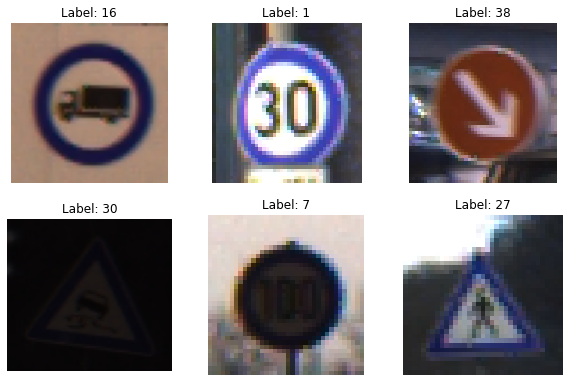

In [9]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Recognition/Lab 1/img_test/"
list_img = os.listdir(img_path)

plt.figure(figsize=(10, 10))

for i in range(len(list_img)):
    # read and preprocess image
    img = cv2.imread(img_path + list_img[i])
    preprocess_img = cv2.resize(img, (32, 32), cv2.INTER_AREA)
    preprocess_img = preprocess_img.transpose(2, 0, 1)
    preprocess_img = preprocess_img / 255.0
    preprocess_img = np.expand_dims(preprocess_img, axis=0)
    preprocess_img = torch.FloatTensor(preprocess_img)

    # predict
    output = predict(convert_model, preprocess_img, device)
    output = output.cpu().detach().numpy()

    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(img)
    plt.title('Label: '+ str(output[0]))